In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt

from pingouin import mixed_anova, pairwise_tests
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm, ols
import statsmodels.formula.api as smf
from astropy.stats import circcorrcoef
from statsmodels.stats.multitest import multipletests

import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
common_fig_folder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/GRAB')
common_fig_folder.mkdir(exist_ok=True, parents=True)

grabda_sess = nmp.grab_sensors.SessMaker(basedir = '/media/mplitt/SSD_storage/2P_scratch/R20A02_R56H10_split_GRABDA2m',
                                         figfolder=common_fig_folder / 'GRABDA2m',
                                         id_suffix='DA')

graboa_sess = nmp.grab_sensors.SessMaker(basedir = '/media/mplitt/SSD_storage/2P_scratch/R20A02_R56H10_split_GRABOA1',
                                         figfolder=common_fig_folder / 'GRABOA1',
                                        id_suffix='OA')



In [3]:
da_stats_df = nmp.grab_sensors.offset_stats(grabda_sess)
da_stats_df_unique = nmp.grab_sensors.offset_stats_unique(da_stats_df)
da_stats_df_plot = nmp.grab_sensors.offset_stats_plot(da_stats_df_unique)

oa_stats_df = nmp.grab_sensors.offset_stats(graboa_sess)
oa_stats_df_unique = nmp.grab_sensors.offset_stats_unique(oa_stats_df)
oa_stats_df_plot = nmp.grab_sensors.offset_stats_plot(oa_stats_df_unique)


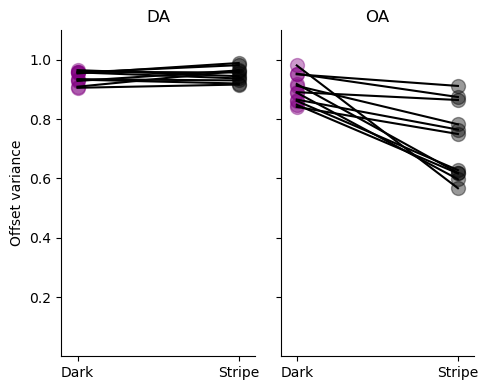

In [29]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=[5,4])

ax[0].set_title('DA')
ax[0].plot([0,1], da_stats_df_plot[['offset_var_dark', 'offset_var_closed_loop']].T, color='black')
ax[0].scatter(np.zeros((da_stats_df_plot.shape[0],)), da_stats_df_plot['offset_var_dark'], color='purple', alpha=.4, s=100)
ax[0].scatter(np.ones((da_stats_df_plot.shape[0],)), da_stats_df_plot['offset_var_closed_loop'], color='black', alpha=.4, s=100)

ax[1].set_title('OA')
ax[1].plot([0,1], oa_stats_df_plot[['offset_var_dark', 'offset_var_closed_loop']].T, color='black')
ax[1].scatter(np.zeros((oa_stats_df_plot.shape[0],)), oa_stats_df_plot['offset_var_dark'], color='purple', alpha=.4, s=100)
ax[1].scatter(np.ones((oa_stats_df_plot.shape[0],)), oa_stats_df_plot['offset_var_closed_loop'], color='black', alpha=.4, s=100)

for _ax in ax:
    _ax.set_ylim([0.0,1.1])
    _ax.set_xlim([-.1,1.1])
    _ax.set_yticks([.2,.4,.6,.8,1.])

    _ax.set_xticks([0, 1], labels=['Dark', 'Stripe'])
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)
    
ax[0].set_ylabel('Offset variance')


fig.tight_layout()
fig.savefig(common_fig_folder / 'offset_variance_summary.pdf', format='pdf', bbox_inches='tight')

In [5]:
# mixed anova
da_stats_df_unique['group'] = 'DA'
oa_stats_df_unique['group'] = 'OA'

stats_df_unique = pd.concat([da_stats_df_unique,oa_stats_df_unique])
aov = mixed_anova(dv='offset_var_logit', between='group',
                  within='dark', subject='fly_id', data=stats_df_unique)
aov


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,16.546652,1,19,16.546652,33.544891,0.000014,0.638404,NaN
1,dark,2.972157,1,19,2.972157,8.626586,0.008459,0.312257,1.0
2,Interaction,6.618350,1,19,6.618350,19.209540,0.000320,0.502742,NaN


In [6]:
tt = pairwise_tests(dv='offset_var_logit', between='group',
                   subject='fly_id', within='dark', data=stats_df_unique,
                   padjust='holm', parametric=True, interaction=True, within_first=False)

tt

,Contrast,group,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,-,DA,OA,False,True,5.837844,18.934719,two-sided,0.000013,NaN,NaN,1161.993,2.429393
1,dark,-,0,1,True,True,-2.124949,20.000000,two-sided,0.046245,NaN,NaN,1.452,-0.528084
2,group * dark,DA,0,1,True,True,1.395236,9.000000,two-sided,0.196413,0.196413,holm,0.66,0.507410
3,group * dark,OA,0,1,True,True,-4.528224,10.000000,two-sided,0.001094,0.002189,holm,37.534,-1.743119


In [7]:
tt = pairwise_tests(dv='offset_var_logit', between='group',
                   subject='fly_id', within='dark', data=stats_df_unique,
                   padjust='holm', parametric=True, interaction=True, within_first=True)

tt

,Contrast,dark,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,dark,-,0,1,True,True,-2.124949,20.000000,two-sided,0.046245,NaN,NaN,1.452,-0.528084
1,group,-,DA,OA,False,True,5.837844,18.934719,two-sided,0.000013,NaN,NaN,1161.993,2.429393
2,dark * group,0,DA,OA,False,True,6.604572,18.870358,two-sided,0.000003,0.000005,holm,4747.651,2.767886
3,dark * group,1,DA,OA,False,True,1.886958,15.713630,two-sided,0.077782,0.077782,holm,1.304,0.770235


In [8]:
def group_rho_df(rho_stats):
    return rho_stats.groupby(['fly_id', 'cl']).apply(
    lambda x: pd.Series({
        'F_dig': np.nanmean(np.stack(x['F_dig']), axis=0),
        'rho_dig': np.nanmean(np.stack(x['rho_dig']), axis=0)
    })).reset_index()

In [9]:
dh_bins = np.linspace(0, 3.14, num=20)

da_stats = nmp.grab_sensors.rho_stats(grabda_sess, dh_bins=dh_bins)
da_stats.loc[da_stats['cl'] > 1, 'cl'] = 1
da_grouped = group_rho_df(da_stats)

oa_stats = nmp.grab_sensors.rho_stats(graboa_sess, dh_bins=dh_bins)
oa_stats.loc[oa_stats['cl'] > 1, 'cl'] = 1
oa_grouped = group_rho_df(oa_stats)




/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:161: RuntimeWarning: Mean of empty slice.
  rho_dig = np.array([ts.rho[dh_dig == i].mean() for i in range(len(dh_bins))])
/home/mplitt/mambaforge/envs/NeuroModPlasticity/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:162: RuntimeWarning: Mean of empty slice.
  F_dig = np.array([ts.outer_ring[dh_dig == i].mean() for i in range(len(dh_bins))])
/tmp/ipykernel_127020/617967456.py:4: RuntimeWarning: Mean of empty slice
  'F_dig': np.nanmean(np.stack(x['F_dig']), axis=0),
/tmp/ipykernel_127020/617967456.py:5: RuntimeWarning: Mean of empty slice
  'rho_dig': np.nanmean(np.stack(x['rho_dig']), axis=0)


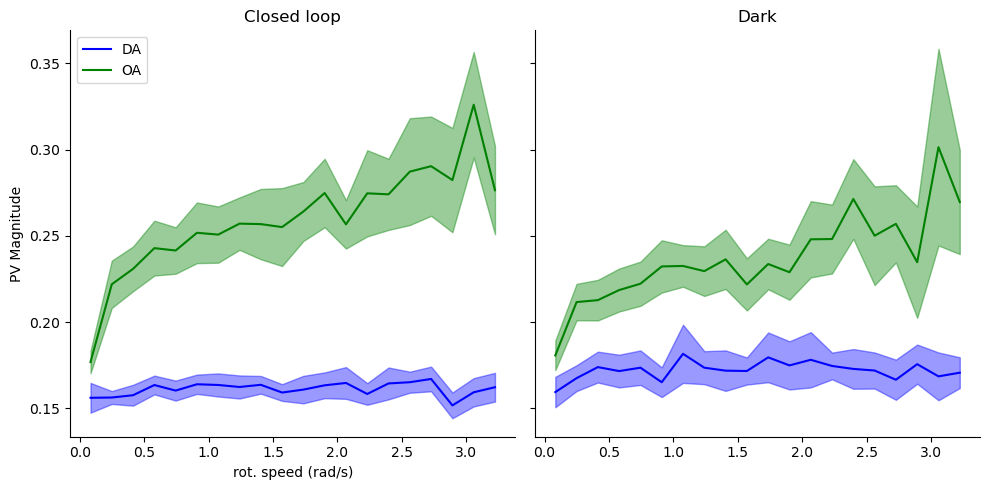

In [30]:
dh_bin_centers = dh_bins+np.diff(dh_bins)[0]/2

fig,ax = plt.subplots(1,2,sharey=True, figsize=[10,5])

rho_dig = np.stack(da_grouped.loc[da_grouped['cl']==1,'rho_dig'])
mu, sem = np.nanmean(rho_dig, axis=0), sp.stats.sem(rho_dig, axis=0, nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='blue', label='DA')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='blue', alpha=.4)

rho_dig = np.stack(da_grouped.loc[da_grouped['cl']==0,'rho_dig'])
mu, sem = np.nanmean(rho_dig, axis=0), sp.stats.sem(rho_dig, axis=0, nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='blue')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='blue', alpha=.4)

rho_dig = np.stack(oa_grouped.loc[oa_grouped['cl']==1,'rho_dig'])
mu, sem = np.nanmean(rho_dig, axis=0), sp.stats.sem(rho_dig, axis=0, nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='green', label='OA')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.4) 

ax[0].legend()

rho_dig = np.stack(oa_grouped.loc[oa_grouped['cl']==0,'rho_dig'])
mu, sem = np.nanmean(rho_dig, axis=0), sp.stats.sem(rho_dig, axis=0, nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='green')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.4)

for _ax in ax:
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)

ax[0].set_title('Closed loop')
ax[1].set_title('Dark')
ax[0].set_ylabel('PV Magnitude')
ax[0].set_xlabel('rot. speed (rad/s)')

fig.tight_layout()
fig.savefig(common_fig_folder / 'PV_magnitude_summary.pdf', format='pdf', bbox_inches='tight')

In [31]:
da_reg_stats = nmp.grab_sensors.reformat_rho_stats_for_reg(da_grouped, dh_bins)
da_reg_stats['group'] = 'DA'
oa_reg_stats = nmp.grab_sensors.reformat_rho_stats_for_reg(oa_grouped, dh_bins)
oa_reg_stats['group'] = 'OA'

reg_stats = pd.concat([da_reg_stats, oa_reg_stats])




/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:193: RuntimeWarning: invalid value encountered in log
  reg_df.reset_index()
/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:193: RuntimeWarning: invalid value encountered in log
  reg_df.reset_index()


In [32]:
aov = mixed_anova(dv='rho', between='group',
                  within='dh', subject='fly_id', data=reg_stats.loc[reg_stats['cl']==1])
aov

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,1.066702,1,21,1.066702,24.295202,7.088734e-05,0.536375,NaN
1,dh,0.092879,19,399,0.004888,6.380773,1.815093e-14,0.233038,0.183745
2,Interaction,0.087805,19,399,0.004621,6.032172,1.632609e-13,0.223148,NaN


In [33]:
model = ols('log_rho ~ dh*C(group)', reg_stats.loc[reg_stats['cl']==1])

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                log_rho   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     207.1
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           6.91e-86
Time:                        11:05:12   Log-Likelihood:                 79.119
No. Observations:                 479   AIC:                            -150.2
Df Residuals:                     475   BIC:                            -133.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.8389      0.02

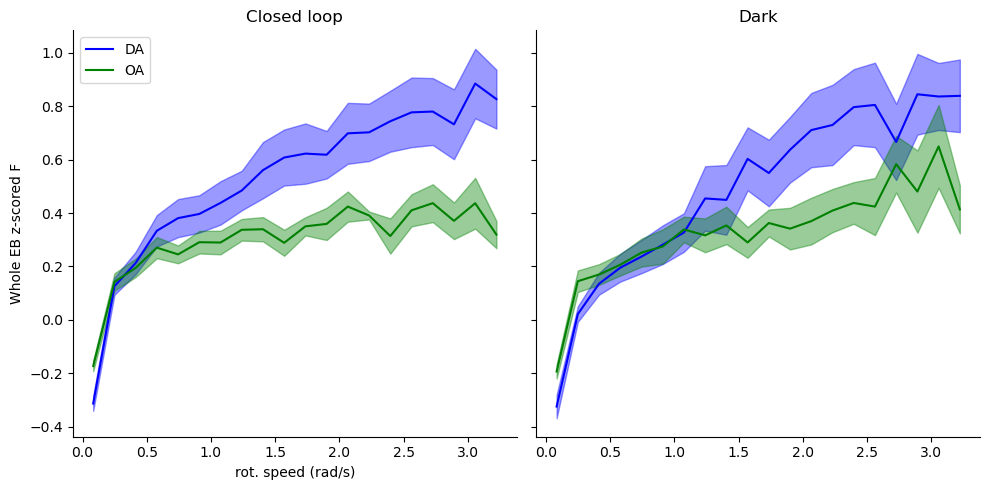

In [34]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=[10,5])

F_dig = np.stack(da_grouped.loc[da_grouped['cl']==1,'F_dig'])
mu, sem = np.nanmean(F_dig, axis=0), sp.stats.sem(F_dig, axis=0, nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='blue', label='DA')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='blue', alpha=.4)

F_dig = np.stack(da_grouped.loc[da_grouped['cl']==0,'F_dig'])
mu, sem = np.nanmean(F_dig, axis=0), sp.stats.sem(F_dig, axis=0, nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='blue')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='blue', alpha=.4)

F_dig = np.stack(oa_grouped.loc[oa_grouped['cl']==1,'F_dig'])
mu, sem = np.nanmean(F_dig, axis=0), sp.stats.sem(F_dig, axis=0, nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='green', label='OA')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.4) 

ax[0].legend()

F_dig = np.stack(oa_grouped.loc[oa_grouped['cl']==0,'F_dig'])
mu, sem = np.nanmean(F_dig, axis=0), sp.stats.sem(F_dig, axis=0, nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='green')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.4)

for _ax in ax:
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)

ax[0].set_title('Closed loop')
ax[1].set_title('Dark')
ax[0].set_ylabel('Whole EB z-scored F')
ax[0].set_xlabel('rot. speed (rad/s)')

fig.tight_layout()
fig.savefig(common_fig_folder / 'F_summary.pdf', format='pdf', bbox_inches='tight')

In [35]:
model = ols('log_F ~ dh*C(group)', reg_stats.loc[reg_stats['cl']==1])

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_F   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     53.71
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           1.21e-29
Time:                        11:06:13   Log-Likelihood:                -479.23
No. Observations:                 449   AIC:                             966.5
Df Residuals:                     445   BIC:                             982.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.5404      0.10

In [43]:
session_folder = grabda_sess.fig_folder / "sessions"
plt.ioff()
for _, row in grabda_sess.sess_df.iterrows():
        
    ts_dict = {'fly': row['fly_id'],
                row['session']: nmp.session.GetTS(grabda_sess.load_row(row))
    }
    
    fig_heatmaps = nmp.grab_sensors.plot_sess_heatmaps(ts_dict, cmap='Blues')
    (fig_hist, ax_hist), (fig_polar, ax_polar) = nmp.grab_sensors.plot_sess_histograms(ts_dict, cmap='Blues')

    fly_folder = session_folder / f"fly{row['fly_id']}"
    fly_folder.mkdir(exist_ok=True, parents=True)

    fig_heatmaps.savefig(fly_folder / "heatmaps.pdf", format='pdf', bbox_inches='tight')
    fig_hist.savefig(fly_folder / "offset_hist.pdf", format='pdf', bbox_inches='tight')
    fig_polar.savefig(fly_folder / "offset_polar.pdf", format='pdf', bbox_inches='tight')

plt.ion()

/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:272: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_polar, ax_polar = plt.subplots(subplot_kw={'projection':'polar'})


In [46]:
session_folder = graboa_sess.fig_folder / "sessions"
plt.ioff()
for _, row in graboa_sess.sess_df.iterrows():
        
    ts_dict = {'fly': row['fly_id'],
                row['session']: nmp.session.GetTS(graboa_sess.load_row(row))
    }
    
    fig_heatmaps = nmp.grab_sensors.plot_sess_heatmaps(ts_dict, cmap='Greens')
    (fig_hist, ax_hist), (fig_polar, ax_polar) = nmp.grab_sensors.plot_sess_histograms(ts_dict, cmap='Greens')

    fly_folder = session_folder / f"fly{row['fly_id']}"
    fly_folder.mkdir(exist_ok=True, parents=True)

    fig_heatmaps.savefig(fly_folder / "heatmaps.pdf", format='pdf', bbox_inches='tight')
    fig_hist.savefig(fly_folder / "offset_hist.pdf", format='pdf', bbox_inches='tight')
    fig_polar.savefig(fly_folder / "offset_polar.pdf", format='pdf', bbox_inches='tight')

    fig_heatmaps.clf()
    fig_hist.clf()
    fig_polar.clf()
    

plt.ion()

/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:272: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_polar, ax_polar = plt.subplots(subplot_kw={'projection':'polar'})


In [47]:
def align_peaks_split_halves(sess_cls):
    first_half_aligned, second_half_aligned = [], []
    for _, row in sess_cls.sess_df.iterrows():
        if row['closed_loop']>0:
            ts = nmp.session.GetTS(sess_cls.load_row(row))
            
            dh_mask = np.abs(ts.dh)>.5
            dff_h_aligned = ts.dff_h_aligned[:,dh_mask]

            n = dff_h_aligned.shape[1]
            split = n//2
            
            
            
            first_half = dff_h_aligned[:,:split].mean(axis=1)
            second_half = dff_h_aligned[:,split:].mean(axis=1)

            shift = np.argmax(first_half)
            first_half_aligned.append(np.roll(first_half, -shift-8))
            second_half_aligned.append(np.roll(second_half, -shift-8, axis=0))

    first_half_aligned = np.stack(first_half_aligned)
    second_half_aligned = np.stack(second_half_aligned)
    return first_half_aligned, second_half_aligned

Text(0.5, 0.98, 'Heading aligned response')

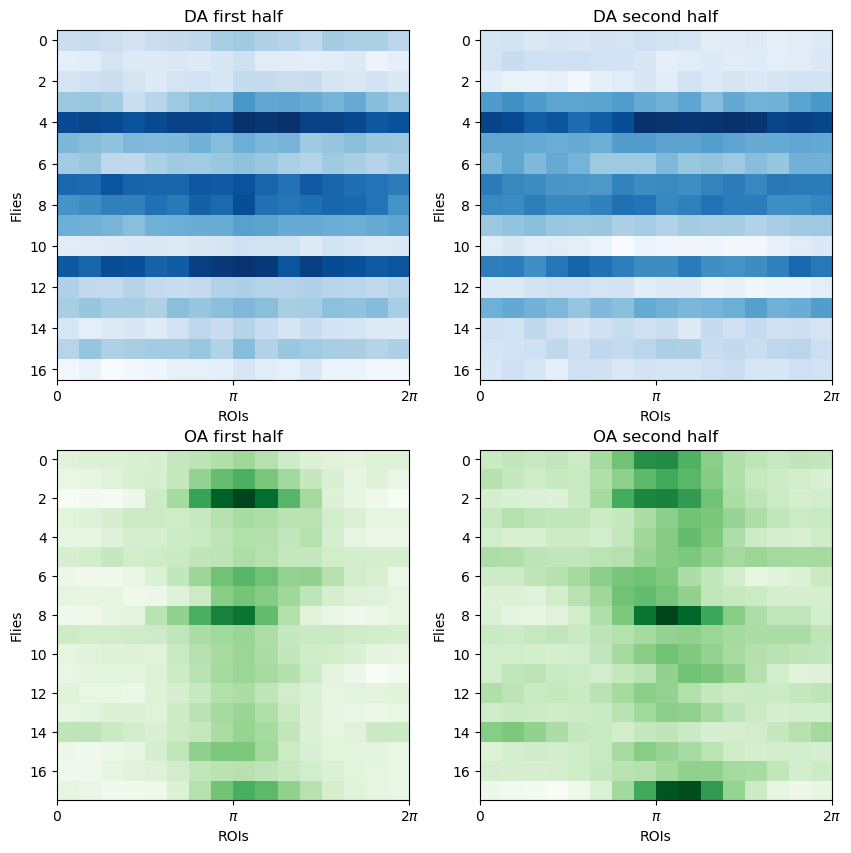

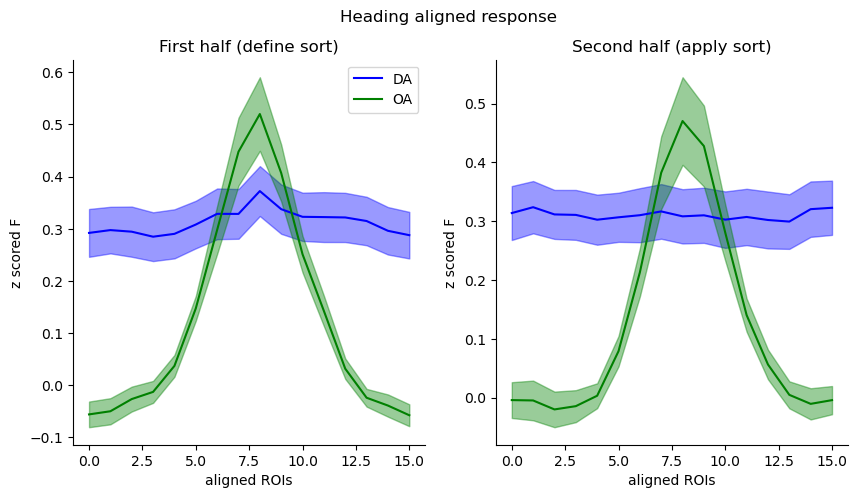

In [49]:
# align GRABOA peaks- split halves
oa_first_half, oa_second_half = align_peaks_split_halves(graboa_sess)
da_first_half, da_second_half = align_peaks_split_halves(grabda_sess)


fig, ax = plt.subplots(2,2, figsize=[10,10])
ax[0,0].imshow(da_first_half, aspect='auto', cmap='Blues')
ax[0,1].imshow(da_second_half, aspect='auto', cmap='Blues')
ax[1,0].imshow(oa_first_half, aspect='auto', cmap='Greens')
ax[1,1].imshow(oa_second_half, aspect='auto', cmap='Greens')


ax[0,0].set_title('DA first half')  
ax[0,1].set_title('DA second half')
ax[1,0].set_title('OA first half')
ax[1,1].set_title('OA second half')
for a in ax.flatten():
    a.set_xlabel('ROIs')
    a.set_ylabel('Flies')
    a.set_xticks([-0.5,7.5,15.5], labels=[r'0', r'$\pi$', r'$2\pi$'])
    # a.set_yticks([])    

fig, ax = plt.subplots(1,2, figsize=[10,5])

mu, sem = da_first_half.mean(axis=0), sp.stats.sem(da_first_half, axis=0, nan_policy='omit')
ax[0].plot(mu, color='blue', label='DA')
ax[0].fill_between(np.arange(mu.shape[0]), mu-sem, mu+sem, color='blue', alpha=.4)

mu, sem = da_second_half.mean(axis=0), sp.stats.sem(da_second_half, axis=0, nan_policy='omit')
ax[1].plot(mu, color='blue')
ax[1].fill_between(np.arange(mu.shape[0]), mu-sem, mu+sem, color='blue', alpha=.4)

mu, sem = oa_first_half.mean(axis=0), sp.stats.sem(oa_first_half, axis=0, nan_policy='omit')
ax[0].plot(mu, color='green', label='OA')
ax[0].fill_between(np.arange(mu.shape[0]), mu-sem, mu+sem, color='green', alpha=.4)

ax[0].legend()

mu, sem = oa_second_half.mean(axis=0), sp.stats.sem(oa_second_half, axis=0, nan_policy='omit')
ax[1].plot(mu, color='green')
ax[1].fill_between(np.arange(mu.shape[0]), mu-sem, mu+sem, color='green', alpha=.4)

ax[0].set_title('First half (define sort)')
ax[1].set_title('Second half (apply sort)')
fig.suptitle('Heading aligned response')

for a in ax:
    a.set_xlabel('aligned ROIs')
    a.set_ylabel('z scored F')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
fig.suptitle('Heading aligned response')
